#  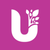   **Universidad de la ciudad de Buenos Aires**

---

# TRABAJO PRÁCTICO - Segundo Módulo: Programación Avanzada en Ciencia de Datos

## Dashboard Interactivo de Análisis de Delitos - Ciudad de Buenos Aires

**Objetivo:** Desarrollo de un dashboard interactivo para el análisis de delitos en la Ciudad de Buenos Aires, implementando un flujo completo de trabajo con datos: adquisición, almacenamiento en base de datos y visualización interactiva.

## 1. Preparación del Entorno

In [20]:
# Librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import sqlite3
import plotly.io as pio
import plotly.graph_objects as go
from IPython.display import HTML

## 2. Adquisición de Datos

In [ ]:
# Crear directorio para datasets
if not os.path.exists("datasets"):
    os.makedirs("datasets")

# Descargar los datasets
!wget --no-check-certificate -O datasets/delitos_2021.csv "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_2021.csv"
!wget --no-check-certificate -O datasets/delitos_2022.csv "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_2022.csv"
!wget --no-check-certificate -O datasets/delitos_2023.csv "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_2023.csv"
!wget --no-check-certificate -O datasets/delitos_2024.csv "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_2024.csv"

In [3]:
# Cargar los dataframes desde los datasets en csv
df1 = pd.read_csv("datasets/delitos_2021.csv")
df2 = pd.read_csv("datasets/delitos_2022.csv")
df3 = pd.read_csv("datasets/delitos_2023.csv")
df4 = pd.read_csv("datasets/delitos_2024.csv")

# Unir los dataframes en un único dataframe
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

## 3. Limpieza y preparación de los datos

In [4]:
# Normalizar texto en columnas categóricas
df['tipo'] = df['tipo'].str.strip().str.title()
df['subtipo'] = df['subtipo'].str.strip().str.title()
df['barrio'] = df['barrio'].str.strip().str.title()
df['comuna'] = df['comuna'].astype(str).str.zfill(2)  # comunas con dos dígitos

# Mapear meses de texto a número
meses_map = {
    "ENERO": 1, "FEBRERO": 2, "MARZO": 3, "ABRIL": 4,
    "MAYO": 5, "JUNIO": 6, "JULIO": 7, "AGOSTO": 8,
    "SEPTIEMBRE": 9, "OCTUBRE": 10, "NOVIEMBRE": 11, "DICIEMBRE": 12
}
df['mes'] = df['mes'].str.upper().map(meses_map)

# Mapear días de texto a número
dias_map = {
    "LUNES": 0, "MARTES": 1, "MIERCOLES": 2, "JUEVES": 3,
    "VIERNES": 4, "SABADO": 5, "DOMINGO": 6
}
df['dia'] = df['dia'].str.upper().map(dias_map)

# Crear columnas con nombres ordenados para meses y días (para gráficos legibles)
df['mes_nombre'] = pd.Categorical(
    df['mes'].map({v:k for k,v in meses_map.items()}),
    categories=list(meses_map.keys()),
    ordered=True
)

df['dia_nombre'] = pd.Categorical(
    df['dia'].map({v:k for k,v in dias_map.items()}),
    categories=list(dias_map.keys()),
    ordered=True
)

# Convertir fecha
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Convertir variables binarias a 0/1
df['uso_arma'] = df['uso_arma'].str.strip().str.lower().map({'si': 1, 'no': 0})
df['uso_moto'] = df['uso_moto'].str.strip().str.lower().map({'si': 1, 'no': 0})

# Asegurar tipo de datos para año y cantidad
df['anio'] = df['anio'].astype(int)
df['cantidad'] = pd.to_numeric(df['cantidad'], errors='coerce').fillna(0).astype(int)

# Filtrar registros sin coordenadas válidas
df = df.dropna(subset=['latitud', 'longitud'])
df = df[(df['latitud'] != 0) & (df['longitud'] != 0)]  # eliminar coordenadas 0,0 si existieran

## 3.1 Preparacion de entorno SQLite y carga de datos (DF -> SQLite)

In [5]:
# Crear carpeta bdd si no existe
if not os.path.exists("bdd"):
    os.makedirs("bdd")

# Definir ruta de la base
db_path = "bdd/delitos_caba.sqlite"

# Conexión a SQLite
conn = sqlite3.connect(db_path)


In [6]:
# Guardar dataframe en tabla 'delitos'
df.to_sql("delitos", conn, if_exists="replace", index=False)

555615

## 3.2 Verificacion de datos en BD SQLite

In [ ]:
# Verificación de datos en SQLite
df_sql = pd.read_sql("SELECT * FROM delitos", conn)
df_sql.head()

## 4. Generación de gráficos de análisis
### 4.1 Delitos por año y tipo

In [ ]:
# Delitos por año y tipo
query = """
    SELECT anio, tipo, COUNT(*) AS cantidad
    FROM delitos
    GROUP BY anio, tipo
    ORDER BY anio ASC, cantidad DESC
"""

# Ejecutar y traer resultados
delitos_anio = pd.read_sql(query, conn)

# Crear gráfico
fig1 = px.bar(
    delitos_anio,
    x="anio", y="cantidad", color="tipo",
    title="Delitos por año y tipo"
)
fig1.update_xaxes(type="category")

# Cambiar títulos de los ejes
fig1.update_layout(
    xaxis_title="Año",
    yaxis_title="Cantidad"
)

# Exportación a HTML parcial
barras_html = fig1.to_html(full_html=False, include_plotlyjs='cdn')
fig1.show()


### 4.2 Delitos por barrio

In [ ]:
# Delitos por Barrio
# Consulta SQL
query = """
    SELECT barrio, tipo, COUNT(*) AS cantidad
    FROM delitos
    GROUP BY barrio, tipo
"""

delitos_barrio = pd.read_sql(query, conn)

# Eliminar filas con valores nulos en columnas jerárquicas
delitos_barrio = delitos_barrio.dropna(subset=["tipo", "barrio"])

# Convertir a string por seguridad (Plotly a veces falla con NaN/None)
delitos_barrio["tipo"] = delitos_barrio["tipo"].astype(str)
delitos_barrio["barrio"] = delitos_barrio["barrio"].astype(str)

# Generar Treemap
fig2 = px.treemap(
    delitos_barrio,
    path=['tipo','barrio'], values='cantidad',
    title="Distribución de delitos por barrio y tipo"
)

# Exportación a HTML
treemap_html = fig2.to_html(full_html=False, include_plotlyjs=False)
fig2.show()

### 4.3 Evolución de delitos por tipo

In [ ]:
# Evolución de delitos por tipo
query = """
    SELECT anio, tipo, COUNT(*) AS cantidad
    FROM delitos
    GROUP BY anio, tipo
    ORDER BY anio
"""
delitos_tipo_anio = pd.read_sql(query, conn)

# Obtener lista de tipos (equivalente a df['tipo'].unique())
tipos = delitos_tipo_anio['tipo'].unique()

# Crear figura
fig3 = go.Figure()

# Agregar una línea por cada tipo
for t in tipos:
    temp = delitos_tipo_anio[delitos_tipo_anio['tipo'] == t]
    fig3.add_trace(go.Scatter(
        x=temp['anio'],
        y=temp['cantidad'],
        mode='lines+markers',
        name=t
    ))

# Actualizar layout con menú de selección
fig3.update_layout(
    title="Evolución de delitos por tipo",
    xaxis_title="Año",
    yaxis_title="Cantidad",
    updatemenus=[dict(
        buttons=[
            dict(label="Todos",
                 method="update",
                 args=[{"visible":[True]*len(tipos)}])
        ] + [
            dict(label=t,
                 method="update",
                 args=[{"visible":[ti==t for ti in tipos]}])
            for t in tipos
        ],
        direction="down"
    )]
)

# Exportación a HTML
linea_html = fig3.to_html(full_html=False, include_plotlyjs=False)
fig3.show()


### 4.4 Geolocalización de delitos

In [ ]:
# Traer datos desde SQLite
query = """
    SELECT latitud, longitud, anio, tipo, cantidad
    FROM delitos
    WHERE latitud IS NOT NULL AND longitud IS NOT NULL
"""
df_map = pd.read_sql(query, conn)

# Extraer listas de años y tipos
anios = sorted(df_map['anio'].unique())
tipos = sorted(df_map['tipo'].unique())

# Crear figura vacía
fig4 = go.Figure()

# Crear un trace por cada combinación de año y tipo
for a in anios:
    for t in tipos:
        df_sub = df_map[(df_map['anio']==a) & (df_map['tipo']==t)]
        if not df_sub.empty:
            fig4.add_trace(go.Densitymapbox(
                lat=df_sub['latitud'],
                lon=df_sub['longitud'],
                z=df_sub['cantidad'],
                radius=10,
                visible=True,  # inicialmente todos visibles
                name=f"{t} {a}"
            ))

# Función auxiliar para visibilidad según selección
def make_visibility(selected_year, selected_type):
    visible = []
    for a in anios:
        for t in tipos:
            if (selected_year == 'Todos' or a == selected_year) and (selected_type == 'Todos' or t == selected_type):
                visible.append(True)
            else:
                visible.append(False)
    return visible

# Crear botones para años
buttons_year = [dict(label='Todos',
                     method='update',
                     args=[{'visible': make_visibility('Todos','Todos')}])]
for a in anios:
    buttons_year.append(dict(label=str(a),
                             method='update',
                             args=[{'visible': make_visibility(a,'Todos')}]))

# Crear botones para tipos
buttons_type = [dict(label='Todos',
                     method='update',
                     args=[{'visible': make_visibility('Todos','Todos')}])]
for t in tipos:
    buttons_type.append(dict(label=t,
                             method='update',
                             args=[{'visible': make_visibility('Todos',t)}]))

# Layout del mapa
fig4.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": -34.61, "lon": -58.38},
    mapbox_zoom=11,
    title="Mapa de Calor de Delitos - CABA",
    updatemenus=[
        dict(buttons=buttons_year, direction="down", x=0, xanchor="left", y=1.05, yanchor="top", showactive=True, pad={"r": 10, "t": 10}),
        dict(buttons=buttons_type, direction="down", x=0.3, xanchor="left", y=1.05, yanchor="top", showactive=True, pad={"r": 10, "t": 10})
    ]
)

# Exportar a HTML
mapa_html = fig4.to_html(full_html=False, include_plotlyjs=False)
fig4.show()

## 5. Exportar Dashboard completo en HTML

In [19]:
# Crear carpeta html
if not os.path.exists("html"):
    os.makedirs("html")

# Combinar todos los graficos en un solo HTML
# Agregando estilo de presentación formal y estructura responsiva
html_dashboard = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Dashboard de Delitos - CABA</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background-color: #f5f5f5;
        }}

        header {{
            background-color: #2c3e50;
            color: white;
            text-align: center;
            padding: 20px 0;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2);
        }}

        h1 {{
            margin: 0;
            font-size: 2em;
        }}

        main {{
            display: grid;
            grid-template-columns: repeat(2, 1fr);  /* 2 gráficos por fila en pantallas grandes */
            gap: 30px;
            padding: 20px;
        }}

        section {{
            background-color: white;
            padding: 20px;
            border-radius: 12px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
            display: flex;
            flex-direction: column;
            align-items: center;
        }}

        section h2 {{
            margin-top: 0;
            font-size: 1.4em;
            color: #34495e;
            text-align: center;
        }}

        .chart-container {{
            width: 100%;
            height: 500px;
        }}

        /* Responsivo: 1 gráfico por fila en tablet y móviles */
        @media (max-width: 1024px) {{
            main {{
                grid-template-columns: 1fr;
            }}
            .chart-container {{
                height: 450px;
            }}
        }}

        @media (max-width: 768px) {{
            .chart-container {{
                height: 400px;
            }}
        }}

        @media (max-width: 480px) {{
            .chart-container {{
                height: 300px;
            }}
        }}
    </style>
</head>
<body>
    <header>
        <h1>Dashboard Interactivo de Delitos - CABA</h1>
    </header>

    <main>
        <section>
            <h2>Delitos por Año y Tipo</h2>
            <div class="chart-container">{barras_html}</div>
        </section>

        <section>
            <h2>Distribución de Delitos por Barrio y Tipo</h2>
            <div class="chart-container">{treemap_html}</div>
        </section>

        <section>
            <h2>Evolución de Delitos por Tipo</h2>
            <div class="chart-container">{linea_html}</div>
        </section>

        <section>
            <h2>Mapa de Calor de Delitos</h2>
            <div class="chart-container">{mapa_html}</div>
        </section>
    </main>
</body>
</html>
"""

# Guardar dashboard en HTML (html/dashboard_delitos_caba.html)
os.makedirs("html", exist_ok=True)
with open("html/dashboard_delitos_caba.html", "w", encoding="utf-8") as f:
    f.write(html_dashboard)
    f.close()

# Llamar al archivo html exportado (Dashboard)
HTML("html/dashboard_delitos_caba.html")